**1. Introduction**
Amazon product reviews play a crucial role in shaping consumer purchasing decisions. However, the massive volume of user-generated reviews makes manual inspection impractical. Sentiment analysis, a subtask of Natural Language Processing (NLP), aims to automatically classify text according to the sentiment expressed by the author.

In this notebook, I perform binary sentiment classification on the Amazon Polarity dataset, where reviews are labelled as either positive or negative. A fine-tune a RoBERTa transformer-based language model, a state-of-the-art Large Language Model (LLM), and compare its performance against a traditional machine learning baseline. This allows us to evaluate the effectiveness of contextual language models on large-scale, noisy, real-world text data.

#2.  Environment Setup & Imports

In [ ]:
#  Environment Setup & Libraries
# This project fine-tunes a RoBERTa model for sentiment classification
# on the Amazon Polarity dataset, and compares it to a TF-IDF baseline.

!pip install -q transformers datasets evaluate scikit-learn accelerate

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset, DatasetDict
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00
Using device: cuda


Dataset Description & Exploration

The Amazon Polarity dataset consists of millions of Amazon product reviews labeled as:

0 - Negative sentiment

1 - Positive sentiment

The dataset is already preprocessed and split into training and testing sets.

In [ ]:
#  Load Dataset
# Amazon Polarity contains positive/negative product reviews.
# Using a standard dataset improves reproducibility.

dataset = load_dataset("amazon_polarity")
dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

# 3. Dataset Exploration and Analysis

In [ ]:
dataset["train"].column_names

['label', 'title', 'content']

In [ ]:
#  Quick Dataset Exploration
# inspect class balance and sample text to understand
# the task before modelling.

sample_df = pd.DataFrame(dataset["train"].shuffle(seed=42).select(range(5000)))
print(sample_df["label"].value_counts())
print("\nExample review:\n")
print(sample_df["content"].iloc[0][:400])


label
0    2548
1    2452
Name: count, dtype: int64

Example review:

All the pretty people in this film. Even the Rudy character played by Michael Madsen. This is adapted from a Jim Thompson novel for cryin' out loud! These are supposed to be marginal characters, not fashion models. Though McQueen and McGraw were attractive (but check out McQueen's crummy prison haircut) they were believable in the role. Baldwin and Bassinger seem like movie stars trying to act lik



Before training the model, we verify the dataset for missing or null values to ensure data quality and avoid unexpected errors during training.
Before training the model, we verify the dataset for missing or null values to ensure data quality and avoid unexpected errors during training.

In [ ]:
# Convert a small subset of the training data to a pandas DataFrame
eda_df = pd.DataFrame(dataset["train"].select(range(10000)))

# Check for null values in each column
eda_df.isnull().sum()

,0
label,0
title,0
content,0


# 4. Exploratory Data Analysis

The dataset was explored to understand both the content and labels. Sample positive and negative reviews were inspected to check label consistency and text patterns. Review lengths were analyzed, with histograms showing mean, median, and 95th percentile values to guide sequence length decisions for modeling. The distribution of labels was visualized, confirming that the dataset is reasonably balanced. Overall, the EDA confirms that the text is suitable for sentiment classification and helps inform preprocessing choices like max_length for tokenization.

In [ ]:
def plot_label_distribution(df, label_column="label", class_names=None):
    """
    Plots the distribution of class labels to assess dataset balance.
    """

    counts = df[label_column].value_counts().sort_index()

    if class_names is None:
        class_names = [str(i) for i in counts.index]

    plt.figure(figsize=(6, 4))
    plt.bar(class_names, counts.values)
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title("Label Distribution")
    plt.tight_layout()
    plt.show()


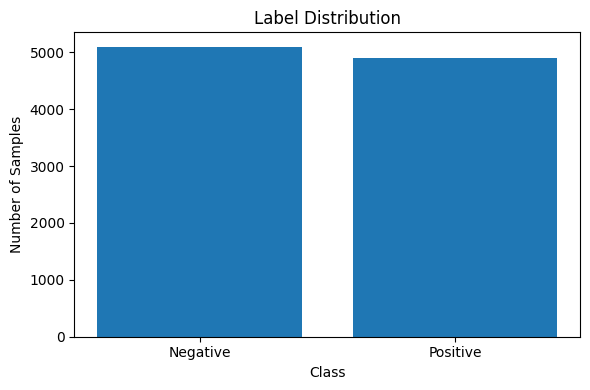

In [ ]:
plot_label_distribution(eda_df, class_names=["Negative", "Positive"])


In [ ]:
def display_sample_reviews(df, text_column="content", label_column="label",
                           samples_per_class=3, max_chars=300):
    """
    Displays sample positive and negative reviews for qualitative inspection.
    This helps verify label correctness and understand class-specific language patterns.
    """

    for label, name in [(1, "Positive"), (0, "Negative")]:
        print(f"{name} Reviews:\n")
        samples = df[df[label_column] == label][text_column].sample(samples_per_class)

        for review in samples:
            print(review[:max_chars], "\n")


In [ ]:
display_sample_reviews(sample_df)


Positive Reviews:

I've been using the battery for nearly a month with no problems. It fit easily into the macbook, and has continued to provide about 3 hours of use per charge. 

Harryq is correct. The album sounds great and all, but the overall release could've been made sweeter. like he said, the album isn't even gatefold. there isn't any special tracks or anything else like that either. also, in the insert with all of the lyrics has quite a few typos. on top of all that,  

The movie sealed the deal for me to be a fan of Angelina Jolie. She was excellent in this movie. It's a tough movie to watch because of the subject matter but you get hooked by the acting. Because of this movie I watchedChangelingalso starting Angelina Jolie. 

Negative Reviews:

I purchased a Brother sewing and embroidery machine on this site in 2005. I believe that model, PE-400D, has been discontinued. And no wonder -- what a piece of junk! In the first six months of use, I had to take it in for a $169 dollar

This cell analyses the length of text reviews in the dataset by calculating the number of words in each review. It then visualises the distribution of review lengths using a histogram to understand how long reviews typically are. To ensure the plot is not distorted by a small number of extremely long reviews, only reviews up to the 95th percentile of review length are included in the visualization. This trimming is applied solely for clarity in visualization and does not remove any data from the dataset itself.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trimmed_review_length_distribution(df, text_column="content", bins=40):
    """
    Computes review length statistics and plots a trimmed distribution.
    The 95th percentile is used to reduce skew for visualization and
    inform maximum sequence length selection.
    """

    lengths = df[text_column].apply(lambda x: len(x.split()))

    # Key statistics
    p95 = np.percentile(lengths, 95)
    mean_len = lengths.mean()
    median_len = lengths.median()

    # Filter extreme values for clearer visualization
    filtered_lengths = lengths[lengths <= p95]

    plt.figure(figsize=(9, 5))

    plt.hist(
        filtered_lengths,
        bins=bins,
        edgecolor="black",
        alpha=0.75,
        label="Review Length Distribution"
    )

    plt.axvline(mean_len, color="red", linestyle="--", linewidth=2, label=f"Mean = {int(mean_len)}")
    plt.axvline(median_len, color="green", linestyle="--", linewidth=2, label=f"Median = {int(median_len)}")
    plt.axvline(p95, color="purple", linestyle=":", linewidth=2, label=f"95th Percentile = {int(p95)}")

    plt.xlabel("Number of Words per Review", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Distribution of Review Lengths (Trimmed for Visualization)", fontsize=14)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


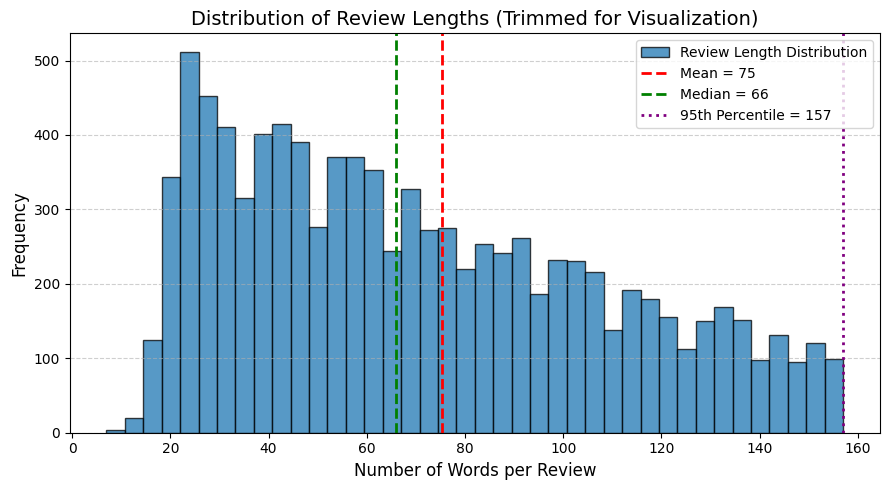

In [ ]:
plot_trimmed_review_length_distribution(eda_df)


This cell visualises the distribution of review lengths using a histogram combined with a density curve. The histogram shows how frequently different review lengths occur, while the kernel density estimation (KDE) curve provides a smooth approximation of the overall shape of the distribution. This combined visualization helps to better understand patterns such as skewness and the presence of long or short reviews in the dataset, making it easier to interpret the overall structure of the text data.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_review_length_distribution(df, column="review_length", bins=50):
    """
    Plots the distribution of review lengths using a histogram with KDE.
    This helps assess text length variability and informs max token length selection.
    """

    plt.figure(figsize=(8, 5))

    sns.histplot(
        df[column],
        bins=bins,
        kde=True
    )

    plt.xlabel("Number of Words per Review", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Distribution of Review Lengths with Density Curve", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


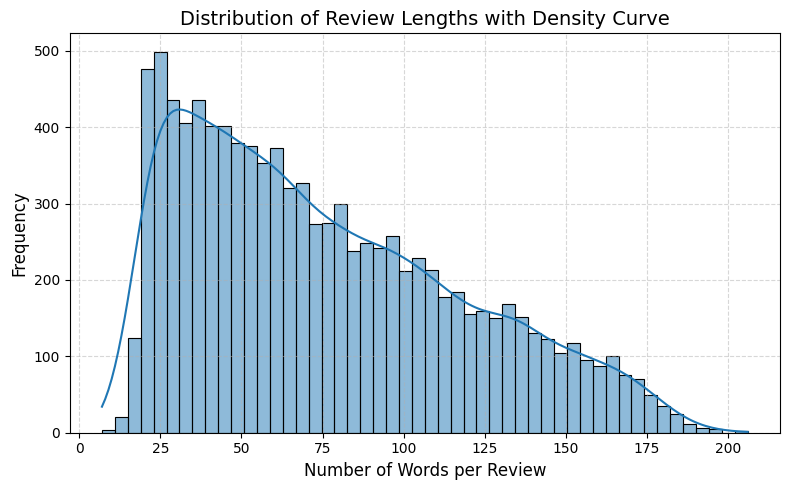

In [ ]:
plot_review_length_distribution(eda_df)


# 5.Methodology(Tokenisation & Preprocessing)

This cell implements the preprocessing and tokenisation stage of the methodology. The RoBERTa tokenizer is used to convert raw text into token IDs, with truncation applied for efficiency and consistent sequence length. The process is implemented as a reusable function so the same pipeline can be applied across training and testing splits. The dataset is tokenised in parallel, unnecessary text columns are removed, and the output is converted into a PyTorch-ready format to support model fine-tuning and reproducibility.

In [ ]:

#  Tokenisation Function
# This function prepares the dataset for RoBERTa by:
# - converting text to token IDs
# - truncating to max length for efficiency
# - enabling parallel mapping for speed

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def preprocess_dataset(dataset, tokenizer, max_len=128,
                       train_size=100000, test_size=20000):

    def tokenize(batch):
        return tokenizer(
            batch["content"],
            padding="max_length",
            truncation=True,
            max_length=max_len
        )

    tokenized = dataset.map(tokenize, batched=True, num_proc=4)
    tokenized = tokenized.remove_columns(["title", "content"])
    tokenized.set_format("torch")

    return DatasetDict({
        "train": tokenized["train"].shuffle(seed=42).select(range(train_size)),
        "test":  tokenized["test"].shuffle(seed=42).select(range(test_size))
    })

tokenized_dataset = preprocess_dataset(dataset, tokenizer)
tokenized_dataset


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/3600000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/400000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
})

This cell defines the evaluation methodology for the model. A reusable function is implemented to compute accuracy, precision, recall, and F1-score from the model outputs. Centralising the metric calculation ensures consistency during validation and testing and supports reproducibility of the experimental results.

In [ ]:
#  Evaluation Metric Function

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    accuracy = accuracy_score(labels, preds)

    return dict(accuracy=accuracy, precision=precision,
                recall=recall, f1=f1)


This cell implements the model training stage of the methodology. A pre-trained RoBERTa model is loaded for binary text classification, and training hyperparameters are defined using the Hugging Face TrainingArguments API. The Trainer object links the model, datasets, tokenizer and evaluation function, and the model is fine-tuned on the training data with evaluation performed at the end of each epoch.

In [ ]:
#  Model Initialisation & Training Function
# Encapsulates model creation and training in a reusable function.
# This improves structure, clarity, and reproducibility.

from transformers import RobertaForSequenceClassification, TrainingArguments, Trainer

def train_roberta_classifier(train_ds, eval_ds, tokenizer, device):
    """
    Initialise and train a RoBERTa sequence-classification model.
    Returns the Trainer object with the best model loaded.
    """

    # Model choice: RoBERTa is suited to sentence-level sentiment tasks
    model = RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels=2
    ).to(device)

    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer


#  Function call
trainer = train_roberta_classifier(
    tokenized_dataset["train"],
    tokenized_dataset["test"],
    tokenizer,
    device
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4214039278.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.176400,0.204711,0.945900,0.942321,0.950393,0.946340
2,0.136500,0.204540,0.951450,0.951954,0.951290,0.951622
3,0.096100,0.227717,0.952450,0.947068,0.958860,0.952928


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
drive_path = "/content/drive/MyDrive/roberta_model"

trainer.model.save_pretrained(drive_path)
tokenizer.save_pretrained(drive_path)

print("Model saved to Google Drive at:", drive_path)


Model saved to Google Drive at: /content/drive/MyDrive/roberta_model


# 6. Model Evaluation & Visualisation

In [ ]:
#  Training Accuracy & Classification Report
from sklearn.metrics import classification_report

def compute_training_accuracy(trainer):
    """
    Compute accuracy on the training dataset.
    """
    preds = trainer.predict(trainer.train_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    accuracy = (y_pred == y_true).mean()
    print(f"Training Accuracy: {accuracy:.4f}")
    return accuracy


def classification_report_eval(trainer, dataset):
    """
    Generate a classification report (precision, recall, F1, support)
    for a selected evaluation dataset.
    """
    preds = trainer.predict(dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    report = classification_report(y_true, y_pred, digits=4)
    print(report)
    return report


#  Function calls
compute_training_accuracy(trainer)
classification_report_eval(trainer, tokenized_dataset["test"])


Training Accuracy: 0.9826


              precision    recall  f1-score   support

           0     0.9509    0.9516    0.9513      9961
           1     0.9520    0.9513    0.9516     10039

    accuracy                         0.9515     20000
   macro avg     0.9514    0.9515    0.9514     20000
weighted avg     0.9515    0.9515    0.9515     20000



'              precision    recall  f1-score   support\n\n           0     0.9509    0.9516    0.9513      9961\n           1     0.9520    0.9513    0.9516     10039\n\n    accuracy                         0.9515     20000\n   macro avg     0.9514    0.9515    0.9514     20000\nweighted avg     0.9515    0.9515    0.9515     20000\n'

This cell defines a function to visualize the training progress of the model. It plots training and validation loss side by side, along with validation accuracy over epochs. These learning curves help to understand how well the model is learning, whether it is overfitting, and how the validation performance changes during training. The function is reusable, so it can be applied to any experiment using the HuggingFace Trainer.

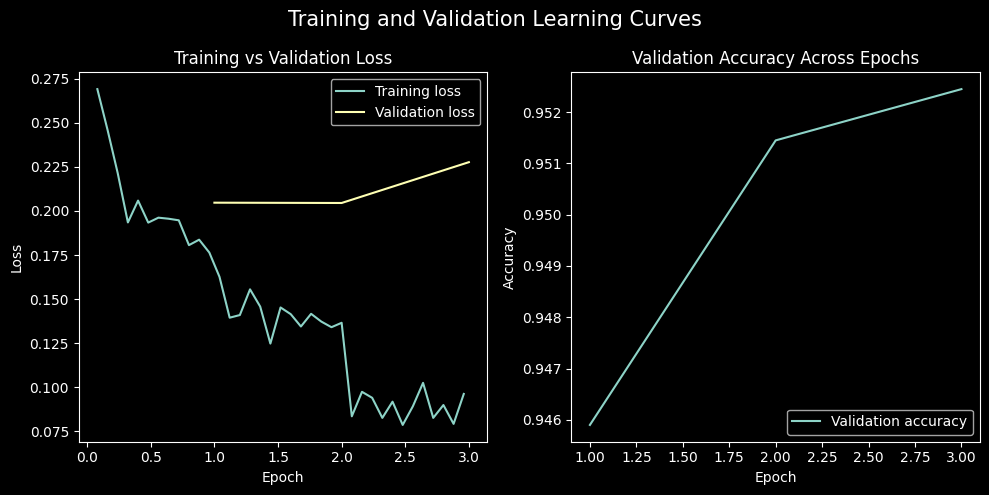

In [ ]:
#  Training Curve Plot Function
# Centralises visualisation logic so plots can be reused
# for different experiments or models. The function takes
# the Trainer log history and produces side-by-side plots
# for training/validation loss and validation accuracy.

def plot_training_curves(trainer_history_df):
    """
    Generate learning-curve plots from HuggingFace Trainer logs.

    Parameters

    trainer_history_df: pandas.DataFrame
        Trainer log history containing loss and evaluation metrics.
    """

    # Separate training and validation metrics to improve clarity
    train_loss = trainer_history_df.dropna(subset=["loss"])[["epoch","loss"]]
    val_logs   = trainer_history_df.dropna(
        subset=["eval_loss","eval_accuracy"]
    )[["epoch","eval_loss","eval_accuracy"]]

    plt.style.use("dark_background")
    plt.figure(figsize=(10,5))
    plt.suptitle("Training and Validation Learning Curves", fontsize=15)

    # Loss Plot
    plt.subplot(1,2,1)
    plt.plot(train_loss["epoch"], train_loss["loss"], label="Training loss")
    plt.plot(val_logs["epoch"], val_logs["eval_loss"], label="Validation loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend(loc="upper right")

    # Accuracy Plot
    plt.subplot(1,2,2)
    plt.plot(val_logs["epoch"], val_logs["eval_accuracy"],
             label="Validation accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Across Epochs")
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


# Function call (re-usable across experiments)
history_df = pd.DataFrame(trainer.state.log_history)
plot_training_curves(history_df)


This function plots the model’s training and validation learning curves side by side. The left plot shows the training and validation loss over epochs, while the right plot shows validation accuracy, with an optional horizontal line for training accuracy as reference. These plots make it easy to monitor model performance, check for overfitting, and compare different experiments in a clear and reusable way.

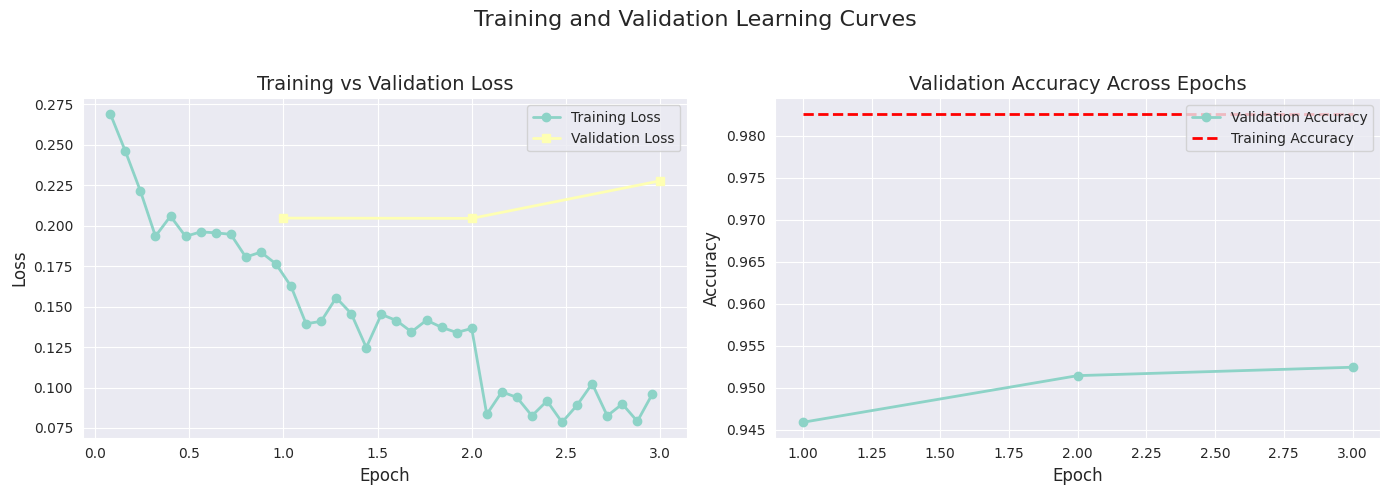

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_training_curves(trainer, train_accuracy=None):
    """
    Plots training & validation loss and validation accuracy side by side
    from HuggingFace Trainer logs.

    Parameters
    ----------
    trainer : transformers.Trainer
        The HuggingFace Trainer object after training.
    train_accuracy : float, optional
        Final training accuracy to display as a reference line in the accuracy plot.
    """


    # Convert Trainer logs to DataFrame

    logs = pd.DataFrame(trainer.state.log_history)

    # Extract Training and Validation Loss

    train_logs = logs[logs["loss"].notna() & logs["epoch"].notna()]
    train_loss = train_logs.groupby("epoch")["loss"].mean()

    eval_logs = logs[logs["eval_loss"].notna()]
    val_loss = eval_logs.set_index("epoch")["eval_loss"]

    # Extract Validation Accuracy

    val_acc_logs = logs[logs["eval_accuracy"].notna()]
    val_accuracy = val_acc_logs.set_index("epoch")["eval_accuracy"]


    # Apply Seaborn style for plots

    sns.set_style("darkgrid")  # Works reliably across environments


    # Plot Side-by-Side

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle("Training and Validation Learning Curves", fontsize=16)

    # Loss Plot
    axes[0].plot(train_loss.index, train_loss, marker="o", linewidth=2, label="Training Loss")
    axes[0].plot(val_loss.index, val_loss, marker="s", linewidth=2, label="Validation Loss")
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].set_ylabel("Loss", fontsize=12)
    axes[0].set_title("Training vs Validation Loss", fontsize=14)
    axes[0].legend()
    axes[0].grid(True)

    #  Accuracy Plot
    axes[1].plot(val_accuracy.index, val_accuracy, marker="o", linewidth=2, label="Validation Accuracy")
    if train_accuracy is not None:
        axes[1].hlines(train_accuracy, xmin=val_accuracy.index.min(),
                       xmax=val_accuracy.index.max(),
                       colors="red", linestyles="dashed",
                       linewidth=2, label="Training Accuracy")
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].set_ylabel("Accuracy", fontsize=12)
    axes[1].set_title("Validation Accuracy Across Epochs", fontsize=14)
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




# Pass the Trainer object and optional training accuracy
plot_training_curves(trainer, train_accuracy=0.9826)


This figure shows the model’s performance on the validation set using confusion matrices. The left plot shows raw counts of predictions for each class, while the right plot shows the normalized values as percentages. Annotated cells make it easy to see both the number of correct/incorrect predictions and the relative accuracy per class, helping to quickly identify if the model is misclassifying any class more than the other.

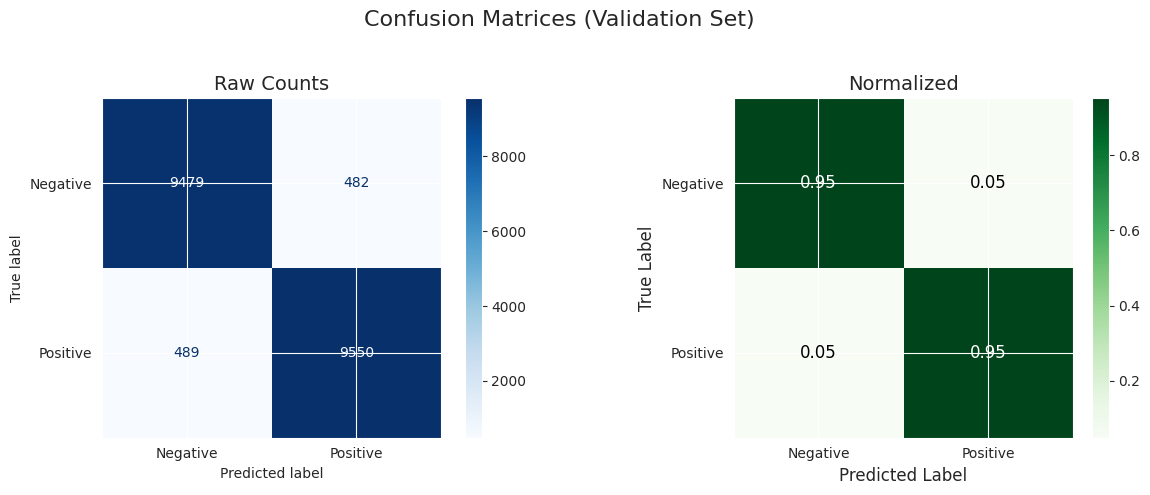

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices_side_by_side(trainer, class_names=None, cmap_raw="Blues", cmap_norm="Greens"):
    """
    Compute and display both raw and normalized confusion matrices side by side
    for the validation dataset of a HuggingFace Trainer.
    """

    # Predict on evaluation dataset

    eval_output = trainer.predict(trainer.eval_dataset)
    preds = np.argmax(eval_output.predictions, axis=1)
    labels = eval_output.label_ids


    # Compute confusion matrices

    cm = confusion_matrix(labels, preds)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


    # Class names

    if class_names is None:
        class_names = ["Class 0", "Class 1"]


    # Plot side by side

    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    fig.suptitle("Confusion Matrices (Validation Set)", fontsize=16)

    # Raw Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=cmap_raw, values_format="d", ax=axes[0])
    axes[0].set_title("Raw Counts", fontsize=14)

    # Normalised Confusion Matrix
    im = axes[1].imshow(cm_norm, interpolation='nearest', cmap=cmap_norm)
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            color = "white" if i == j else "black"
            axes[1].text(j, i, f"{cm_norm[i, j]:.2f}",
                         ha="center", va="center", color=color, fontsize=12)
    axes[1].set_xticks(range(len(class_names)))
    axes[1].set_yticks(range(len(class_names)))
    axes[1].set_xticklabels(class_names)
    axes[1].set_yticklabels(class_names)
    axes[1].set_xlabel("Predicted Label", fontsize=12)
    axes[1].set_ylabel("True Label", fontsize=12)
    axes[1].set_title("Normalized", fontsize=14)

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


plot_confusion_matrices_side_by_side(trainer, class_names=["Negative", "Positive"])


# Baseline Model Logistic Regression + TF-IDF

This cell defines the baseline model used for comparison. The TF-IDF feature extractor and Logistic Regression classifier are implemented inside a reusable function so the model can be easily re-trained or repeated. The function trains the model, makes predictions, and returns accuracy, precision, recall, and F1-score for evaluation.

In [ ]:

#  Baseline Model Function


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report
)

def train_baseline_tfidf_lr(X_train, y_train, X_test, y_test,
                            max_features=5000, C=1.0):
    """
    Trains and evaluates a TF-IDF + Logistic Regression baseline model.
    Wrapped in a function to support code re-use and structured design.
    """

    baseline_model = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=max_features)),
        ("clf",  LogisticRegression(max_iter=1000, C=C))
    ])

    baseline_model.fit(X_train, y_train)
    preds = baseline_model.predict(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds, average="binary"
    )
    accuracy = accuracy_score(y_test, preds)

    metrics = dict(
        accuracy=accuracy,
        precision=precision,
        recall=recall,
        f1=f1
    )

    print("Baseline TF-IDF + Logistic Regression Evaluation")
    print(metrics)
    print("\nClassification Report:\n")
    print(classification_report(y_test, preds, digits=4))

    return baseline_model, metrics


This cell prepares the training and test subsets and calls the baseline model function. The function is executed to train the TF-IDF + Logistic Regression model and print the evaluation results so they can be compared with the RoBERTa model.

In [ ]:

#  Run Baseline Model
# Prepare dataset subsets for baseline benchmarking
X_train = dataset["train"]["content"][:100000]
y_train = dataset["train"]["label"][:100000]
X_test  = dataset["test"]["content"][:20000]
y_test  = dataset["test"]["label"][:20000]

baseline_model, baseline_metrics = train_baseline_tfidf_lr(
    X_train, y_train, X_test, y_test
)


Baseline TF-IDF + Logistic Regression Evaluation
{'accuracy': 0.867, 'precision': 0.8649980672593738, 'recall': 0.8763461915018602, 'f1': 0.8706351522225464}

Classification Report:

              precision    recall  f1-score   support

           0     0.8691    0.8572    0.8632      9786
           1     0.8650    0.8763    0.8706     10214

    accuracy                         0.8670     20000
   macro avg     0.8671    0.8668    0.8669     20000
weighted avg     0.8670    0.8670    0.8670     20000



In [ ]:

#  Confusion Matrix Utility
# This function plots a confusion matrix for any model output.
# It improves code quality by keeping the visualisation reusable
# and separated from the main experiment workflow.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, pred_labels, title="Confusion Matrix"):
    """
    Plots a confusion matrix for model evaluation.

    Parameters
    ----------
    true_labels : array-like
        Ground-truth class labels.
    pred_labels : array-like
        Predicted class labels from the model.
    title : str
        Title displayed on the confusion matrix plot.
    """

    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["Negative","Positive"])

    plt.figure(figsize=(5,4))
    disp.plot(cmap="Oranges", values_format="d")
    plt.title(title)
    plt.show()


<Figure size 500x400 with 0 Axes>

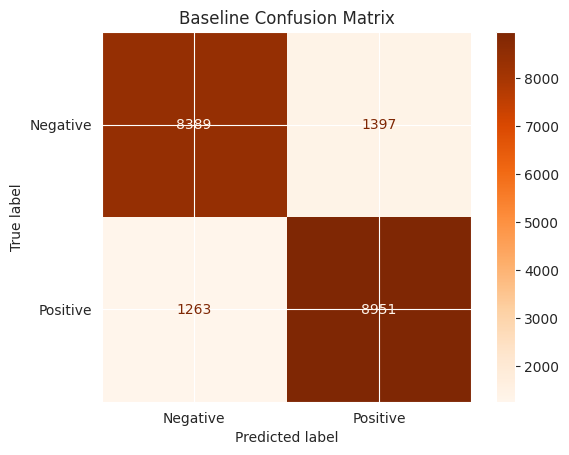

In [ ]:
baseline_preds = baseline_model.predict(X_test)
plot_confusion_matrix(y_test, baseline_preds,
                      title="Baseline Confusion Matrix")

# Model Comparison (Baseline vs RoBERTa)

In this cell, I calculate the accuracy of both models (the Baseline model and the RoBERTa model) and compare them.
First, I generate predictions for each model and compute their accuracy scores.
Then, I create a bar chart to visually compare the two accuracies, so we can clearly see which model performs better.

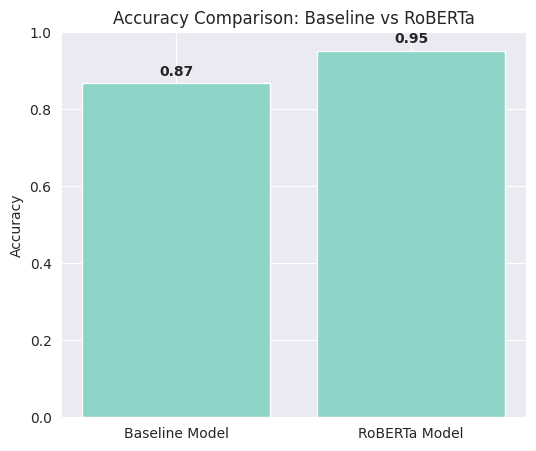

In [ ]:
# Accuracy Comparison: Baseline Model vs RoBERTa Model
# This cell calculates and compares accuracy scores for both models
# and visualises them in a clear bar chart.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# RoBERTa Evaluation
# We use the trainer to generate predictions on the test set
roberta_eval = trainer.predict(trainer.eval_dataset)

# Convert logits to predicted class labels
roberta_preds = np.argmax(roberta_eval.predictions, axis=1)

# True labels from the dataset
roberta_true = roberta_eval.label_ids

# Calculate RoBERTa accuracy
roberta_accuracy = accuracy_score(roberta_true, roberta_preds)

# Baseline Accuracy
# The baseline_metrics dictionary contains the accuracy from the previous cell.
baseline_accuracy = baseline_metrics['accuracy']

# Create comparison bar chart
models = ["Baseline Model", "RoBERTa Model"]
accuracy_values = [baseline_accuracy, roberta_accuracy]

plt.figure(figsize=(6,5))
plt.bar(models, accuracy_values)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Baseline vs RoBERTa")

# Add accuracy labels above bars
for i, v in enumerate(accuracy_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.show()

# Classification Report Comparison Table

This cell is part of the evaluation and comparison stage. A reusable function is created to calculate the main performance metrics (accuracy, precision, recall and F1-score) for any model. The function is then applied to both the Baseline model and the RoBERTa model so the results can be compared fairly. Finally, the metrics are visualised in a bar chart to clearly show the performance difference between the two models.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def get_classification_metrics(y_true, y_pred):
    """
    Computes evaluation metrics for a model in a reusable way.
    Returns accuracy, precision, recall and F1 (binary averaged).
    """
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary"
    )

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
# Baseline metrics
baseline_metrics = get_classification_metrics(y_test, baseline_preds)

# RoBERTa validation metrics
eval_output = trainer.predict(trainer.eval_dataset)
roberta_preds = np.argmax(eval_output.predictions, axis=1)
roberta_labels = eval_output.label_ids

roberta_metrics = get_classification_metrics(roberta_labels, roberta_preds)

print("Baseline Metrics:", baseline_metrics)
print("RoBERTa Metrics:", roberta_metrics)


Baseline Metrics: {'accuracy': 0.867, 'precision': 0.8649980672593738, 'recall': 0.8763461915018602, 'f1': 0.8706351522225464}
RoBERTa Metrics: {'accuracy': 0.95145, 'precision': 0.9519537480063796, 'recall': 0.9512899691204303, 'f1': 0.9516217428130138}


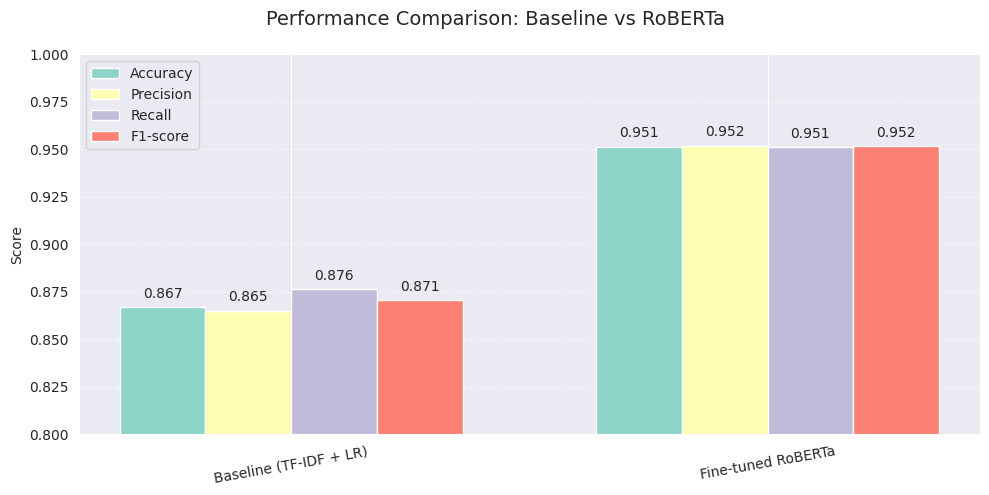

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ["Baseline (TF-IDF + LR)", "Fine-tuned RoBERTa"]

# Extract metric values dynamically
accuracy  = [baseline_metrics["accuracy"],  roberta_metrics["accuracy"]]
precision = [baseline_metrics["precision"], roberta_metrics["precision"]]
recall    = [baseline_metrics["recall"],    roberta_metrics["recall"]]
f1        = [baseline_metrics["f1"],        roberta_metrics["f1"]]

# Bar position settings
x = np.arange(len(models))
width = 0.18

plt.figure(figsize=(10,5))
plt.suptitle("Performance Comparison: Baseline vs RoBERTa", fontsize=14)

# Metric bars
plt.bar(x - 1.5*width, accuracy,  width, label="Accuracy")
plt.bar(x - 0.5*width, precision, width, label="Precision")
plt.bar(x + 0.5*width, recall,    width, label="Recall")
plt.bar(x + 1.5*width, f1,        width, label="F1-score")

#  Styling
plt.xticks(x, models, rotation=10)
plt.ylabel("Score")
plt.ylim(0.80, 1.00)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()

#  Annotate values
for i, metric_list in enumerate([accuracy, precision, recall, f1]):
    for j, value in enumerate(metric_list):
        plt.text(j + (i-1.5)*width, value + 0.005, f"{value:.3f}", ha="center")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Create comparison table
comparison_df = pd.DataFrame({
    "Model": ["Baseline (TF-IDF + Logistic Regression)", "Fine-tuned RoBERTa"],
    "Accuracy":  [baseline_metrics["accuracy"],  roberta_metrics["accuracy"]],
    "Precision": [baseline_metrics["precision"], roberta_metrics["precision"]],
    "Recall":    [baseline_metrics["recall"],    roberta_metrics["recall"]],
    "F1-Score":  [baseline_metrics["f1"],        roberta_metrics["f1"]]
})

comparison_df = comparison_df.set_index("Model")
display(comparison_df.style.format("{:.4f}"))


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Baseline (TF-IDF + Logistic Regression),0.8670,0.8650,0.8763,0.8706
Fine-tuned RoBERTa,0.9515,0.9520,0.9513,0.9516
